In [1]:
#import dependecies
import pandas as pd
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#import dependencies for ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.model_selection import validation_curve
import math
from math import sqrt


#import dependencies for graphs
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import seaborn as sns; sns.set_theme(color_codes=True)
sns.set_context("paper")


In [2]:
#connect to a sqlite3 db
conn = sqlite3.connect(r'/Users/rosaicelaroman/Desktop/portfolio_work/earthquake_modeling/Database/db/earthquake_db')
print("Connected to database...")

Connected to database...


In [3]:
#create dataframe reading all rows from sqlite database
model_df = pd.read_sql_query("SELECT * FROM earthquake_raw", conn)
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06T01:42:39.855Z,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290000,4.0,automatic,nn,nn
1,2022-01-06T01:31:33.698Z,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460000,5.0,automatic,nn,nn
2,2022-01-06T01:24:20.083Z,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06T01:15:15.851Z,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06T01:10:44.629Z,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44892,2022-03-21T04:48:46.720Z,38.823833,-122.808000,3.90,0.43,md,14.0,98.00,0.001678,0.0400,...,2022-03-21T20:17:52.874Z,"7km NW of The Geysers, CA",earthquake,0.39,0.28,0.151000,3.0,reviewed,nc,nc
44893,2022-03-21T04:46:01.380Z,38.821835,-122.760834,1.85,0.85,md,7.0,127.00,0.011170,0.0100,...,2022-03-21T05:29:21.342Z,"3km W of Cobb, CA",earthquake,0.48,0.96,NaN,1.0,automatic,nc,nc
44894,2022-03-21T04:41:58.710Z,19.870000,-155.577000,20.18,1.63,md,24.0,120.00,NaN,0.1500,...,2022-03-22T00:38:03.450Z,"19 km SSE of Waimea, Hawaii",earthquake,0.46,0.99,0.124445,15.0,reviewed,hv,hv
44895,2022-03-21T04:39:20.420Z,38.801666,-122.815498,3.22,0.35,md,7.0,161.00,0.012880,0.0100,...,2022-03-21T04:56:14.173Z,"6km WNW of The Geysers, CA",earthquake,0.59,1.06,NaN,1.0,automatic,nc,nc


In [4]:
#converting time to datetime
model_df['time'] = pd.to_datetime(model_df['time'])
model_df

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-01-06 01:42:39.855000+00:00,37.384000,-117.107500,1.10,1.30,ml,8.0,149.46,0.875000,0.2175,...,2022-01-06T01:47:19.317Z,"37 km SSE of Goldfield, Nevada",earthquake,NaN,39.10,0.290000,4.0,automatic,nn,nn
1,2022-01-06 01:31:33.698000+00:00,38.181000,-117.818000,7.30,1.40,ml,11.0,154.64,0.119000,0.1017,...,2022-01-06T01:47:40.245Z,"34 km SE of Mina, Nevada",earthquake,NaN,2.00,0.460000,5.0,automatic,nn,nn
2,2022-01-06 01:24:20.083000+00:00,61.340700,-149.885200,30.00,1.50,ml,NaN,NaN,NaN,0.7500,...,2022-01-06T01:29:22.015Z,"5 km ESE of Point MacKenzie, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak
3,2022-01-06 01:15:15.851000+00:00,62.870300,-150.762500,111.30,2.10,ml,NaN,NaN,NaN,0.3200,...,2022-01-06T01:29:21.875Z,"41 km N of Petersville, Alaska",earthquake,NaN,0.80,NaN,NaN,automatic,ak,ak
4,2022-01-06 01:10:44.629000+00:00,64.014500,-148.765700,1.90,1.50,ml,NaN,NaN,NaN,0.7200,...,2022-01-06T01:15:56.292Z,"17 km E of Ferry, Alaska",earthquake,NaN,0.60,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44892,2022-03-21 04:48:46.720000+00:00,38.823833,-122.808000,3.90,0.43,md,14.0,98.00,0.001678,0.0400,...,2022-03-21T20:17:52.874Z,"7km NW of The Geysers, CA",earthquake,0.39,0.28,0.151000,3.0,reviewed,nc,nc
44893,2022-03-21 04:46:01.380000+00:00,38.821835,-122.760834,1.85,0.85,md,7.0,127.00,0.011170,0.0100,...,2022-03-21T05:29:21.342Z,"3km W of Cobb, CA",earthquake,0.48,0.96,NaN,1.0,automatic,nc,nc
44894,2022-03-21 04:41:58.710000+00:00,19.870000,-155.577000,20.18,1.63,md,24.0,120.00,NaN,0.1500,...,2022-03-22T00:38:03.450Z,"19 km SSE of Waimea, Hawaii",earthquake,0.46,0.99,0.124445,15.0,reviewed,hv,hv
44895,2022-03-21 04:39:20.420000+00:00,38.801666,-122.815498,3.22,0.35,md,7.0,161.00,0.012880,0.0100,...,2022-03-21T04:56:14.173Z,"6km WNW of The Geysers, CA",earthquake,0.59,1.06,NaN,1.0,automatic,nc,nc


In [5]:
#review names of all columns (features)
for col in model_df.columns:
    print(col)

time
latitude
longitude
depth
mag
magType
nst
gap
dmin
rms
net
id
updated
place
type
horizontalError
depthError
magError
magNst
status
locationSource
magSource


In [6]:
#drop columns not needed
cleaned_df = model_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_df

,latitude,longitude,depth,mag
0,37.384000,-117.107500,1.10,1.30
1,38.181000,-117.818000,7.30,1.40
2,61.340700,-149.885200,30.00,1.50
3,62.870300,-150.762500,111.30,2.10
4,64.014500,-148.765700,1.90,1.50
...,...,...,...,...
44892,38.823833,-122.808000,3.90,0.43
44893,38.821835,-122.760834,1.85,0.85
44894,19.870000,-155.577000,20.18,1.63
44895,38.801666,-122.815498,3.22,0.35


In [7]:
#find if any column has NaNs
cleaned_df.isnull().sum()

latitude     0
longitude    0
depth        0
mag          6
dtype: int64

In [8]:
#drop NaNs
cleaned_df_dropped = cleaned_df.dropna()

In [9]:
#verify dropped NaNs
cleaned_df_dropped.isnull().sum()

latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [10]:
#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X = cleaned_df_dropped.drop(['latitude'], axis = 1)

y = cleaned_df_dropped[['latitude']]

In [11]:
#checking number of columns and rows for eacg feature
X.shape, y.shape

((44891, 3), (44891, 1))

In [12]:
#split dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

Extra Trees Regressor

In [13]:
#create and run model: First with 50 estimators
scores = []
estimators_lst=[]

for i in range(1,50):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    scores.append(score)
    estimators_lst.append(score)

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2 score:", r2, end = ", ")
    print("\tModel score:", score)
max_score = max(scores)
print("Max score:", max_score)
index_max_score = scores.index(max_score) #find the position in the list for max score to get the number of estimators
best_score = max_score
best_model = ExtraTreesRegressor(n_estimators=index_max_score+2, random_state=0)
best_model.fit(X_train, y_train)
best_model_score = best_model.score(X_test, y_test)
print("Best model score: ", best_model_score)


n_estimators=2:
	Mean Squared Error: 60.605608406732145, 	R2 score: 0.8554739920488064, 	Model score: 0.8554739920488064
n_estimators=3:
	Mean Squared Error: 56.65500260209846, 	R2 score: 0.8648949895594773, 	Model score: 0.8648949895594773
n_estimators=4:
	Mean Squared Error: 53.65216865347925, 	R2 score: 0.8720558384403548, 	Model score: 0.8720558384403548
n_estimators=5:
	Mean Squared Error: 51.82073026573132, 	R2 score: 0.8764232639303096, 	Model score: 0.8764232639303096
n_estimators=6:
	Mean Squared Error: 50.79797724687736, 	R2 score: 0.8788622199084922, 	Model score: 0.8788622199084922
n_estimators=7:
	Mean Squared Error: 50.52509948409202, 	R2 score: 0.8795129506700637, 	Model score: 0.8795129506700637
n_estimators=8:
	Mean Squared Error: 50.15217483336415, 	R2 score: 0.8804022629375784, 	Model score: 0.8804022629375784
n_estimators=9:
	Mean Squared Error: 49.117245412131595, 	R2 score: 0.8828702559450599, 	Model score: 0.8828702559450599
n_estimators=10:
	Mean Squared Error: 

In [14]:
#create and run model: Now with 100 max estimators if no improvement of the score is found
scores = []
counter = 0
import time
start_time = time.perf_counter()
for i in range(1,100):
    model = ExtraTreesRegressor(n_estimators=i+1, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)

    r2 = r2_score(y_test, y_pred)
    score = model.score(X_test, y_test)
    estimators = i+1
    current_score = score
    num_estimators = estimators

    print("n_estimators={}:".format(estimators))
    print("\tMean Squared Error:", mse, end = ", ")
    print("\tR2:", r2, end = ", ")
    print("\tModel score:", score)
    if current_score > best_score:
        best_score = current_score
        best_model = model
        num_estimators=i+1
        print('Improvement found!')
        counter = 0
    else:
        counter += 1
    if counter > 60:
        break

end_time = time.perf_counter()
execution_time = end_time - start_time

print(f'Best score found: {best_score:.3f}.')
print(f'Number of estimators: {num_estimators}.')
print(f'Code execution time: {execution_time:.3f} seconds.')

n_estimators=2:
	Mean Squared Error: 60.605608406732145, 	R2: 0.8554739920488064, 	Model score: 0.8554739920488064
n_estimators=3:
	Mean Squared Error: 56.65500260209846, 	R2: 0.8648949895594773, 	Model score: 0.8648949895594773
n_estimators=4:
	Mean Squared Error: 53.65216865347925, 	R2: 0.8720558384403548, 	Model score: 0.8720558384403548
n_estimators=5:
	Mean Squared Error: 51.82073026573132, 	R2: 0.8764232639303096, 	Model score: 0.8764232639303096
n_estimators=6:
	Mean Squared Error: 50.79797724687736, 	R2: 0.8788622199084922, 	Model score: 0.8788622199084922
n_estimators=7:
	Mean Squared Error: 50.52509948409202, 	R2: 0.8795129506700637, 	Model score: 0.8795129506700637
n_estimators=8:
	Mean Squared Error: 50.15217483336415, 	R2: 0.8804022629375784, 	Model score: 0.8804022629375784
n_estimators=9:
	Mean Squared Error: 49.117245412131595, 	R2: 0.8828702559450599, 	Model score: 0.8828702559450599
n_estimators=10:
	Mean Squared Error: 48.66688472220972, 	R2: 0.8839442296970554, 	Mod

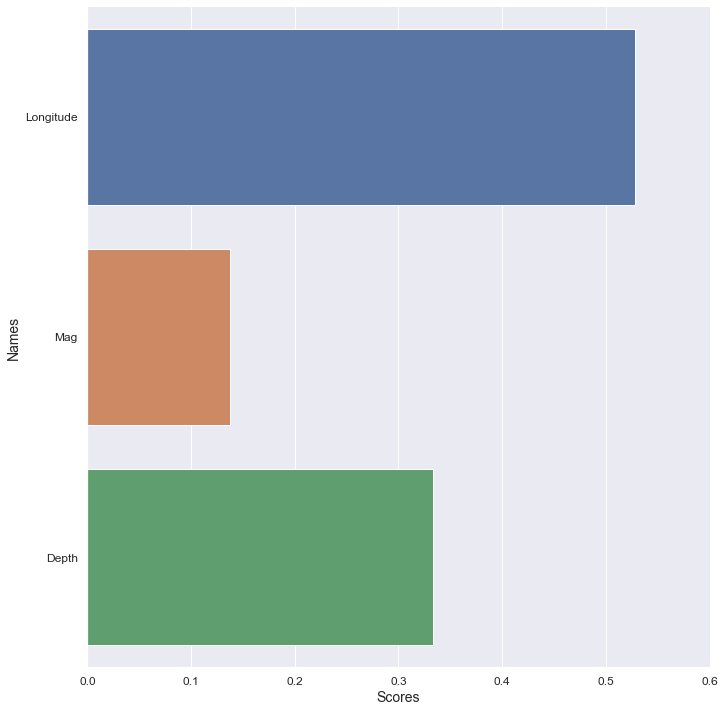

In [15]:
#visualize gini importance
features_lst = []
gini_score_lst = []
for feature, score in zip(cleaned_df_dropped[['longitude', 'mag', 'depth']],best_model.feature_importances_):
    features_lst.append(feature)
    gini_score_lst.append(score)
feature_lst = [feature.capitalize() for feature in features_lst]
d = {'Names': feature_lst, 'Scores': gini_score_lst}
gini_df = pd.DataFrame(d)

sns.set()

p = sns.catplot(y='Names', x="Scores", data=gini_df, kind='bar', height=10, aspect=1, legend=False)
p.set_ylabels(fontsize=14)
p.set_yticklabels(fontsize=12)
p.set_xticklabels(fontsize=12)
p.set_xlabels(fontsize=14)
plt.show()

Cross-Validation

In [16]:
#define number of splits
k_fold = KFold(n_splits=10)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))


Train: [ 4490  4491  4492 ... 44888 44889 44890] | test: [   0    1    2 ... 4487 4488 4489]
Train: [    0     1     2 ... 44888 44889 44890] | test: [4490 4491 4492 ... 8976 8977 8978]
Train: [    0     1     2 ... 44888 44889 44890] | test: [ 8979  8980  8981 ... 13465 13466 13467]
Train: [    0     1     2 ... 44888 44889 44890] | test: [13468 13469 13470 ... 17954 17955 17956]
Train: [    0     1     2 ... 44888 44889 44890] | test: [17957 17958 17959 ... 22443 22444 22445]
Train: [    0     1     2 ... 44888 44889 44890] | test: [22446 22447 22448 ... 26932 26933 26934]
Train: [    0     1     2 ... 44888 44889 44890] | test: [26935 26936 26937 ... 31421 31422 31423]
Train: [    0     1     2 ... 44888 44889 44890] | test: [31424 31425 31426 ... 35910 35911 35912]
Train: [    0     1     2 ... 44888 44889 44890] | test: [35913 35914 35915 ... 40399 40400 40401]
Train: [    0     1     2 ... 40399 40400 40401] | test: [40402 40403 40404 ... 44888 44889 44890]


In [17]:
#calculate cross-validation score
from numpy import mean
from numpy import std

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cv_score=cross_val_score(best_model, X, y.values.ravel(), scoring='neg_mean_absolute_error', cv=k_fold, n_jobs=-1)
    print(cv_score)

# report performance
print('MAE: %.3f (%.3f)' % (mean(cv_score), std(cv_score)))

[-1.78847852 -2.55070656 -2.00937402 -2.1153583  -1.99835051 -2.29095288
 -2.17658198 -1.91873867 -1.81218774 -1.96836207]
MAE: -2.063 (0.219)


In [18]:
#define tree for plot validation curve
reg_etrees = ExtraTreesRegressor(n_estimators=100, random_state=0)

In [19]:
##create elements for plot validation curve
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
param_range = np.linspace(1, 100, 5, dtype=int)
train_scores, test_scores = validation_curve(
    reg_etrees,
    X,
    y.values.ravel(),
    param_name="n_estimators",
    param_range=param_range,
    n_jobs=2,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

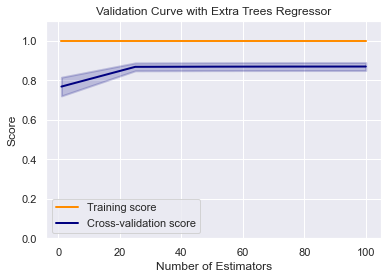

In [20]:
#plot validation curve
plt.title("Validation Curve with Extra Trees Regressor")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [21]:
#use the best model to make predictions
testpred = best_model.predict(X_test)
actual_lat = y_test
lats = actual_lat['latitude'].tolist()
testpredict = []
abs_error = []
for item in testpred:
    testpredict.append(item)

maerr=mean_absolute_error(lats, testpredict)
test_mse = mean_squared_error(y_test, testpred)

test_mse = mean_squared_error(y_test, testpred)
rmse = sqrt(test_mse)
print('RMSE: %.3f' % rmse)
print('MAE: %.3f' % maerr)

RMSE: 6.796
MAE: 1.874


In [22]:
lat_pred = actual_lat
lat_pred['Predicted'] = testpredict


In [23]:
lat_pred = lat_pred.rename(columns={'latitude': 'Actual'})

In [24]:
lat_pred.head(5)

,Actual,Predicted
20932,23.440600,25.180897
2503,37.490333,38.574560
6320,46.887833,46.228422
4336,58.202900,63.066920
4139,33.998333,33.696133


In [25]:
#join dataframes for actual and predicted with original dataframe
lat_pred_all = lat_pred.merge(model_df, how='inner', left_index=True, right_index=True)
lat_pred_all

,Actual,Predicted,time,latitude,longitude,depth,mag,magType,nst,gap,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
20932,23.440600,25.180897,2022-02-13 15:00:15.296000+00:00,23.440600,126.210700,10.00,4.10,mb,NaN,142.00,...,2022-02-17T20:11:31.040Z,"176 km SSE of Hirara, Japan",earthquake,11.40,2.00,0.303000,3.0,reviewed,us,us
2503,37.490333,38.574560,2021-12-26 16:40:12.940000+00:00,37.490333,-119.381667,8.46,1.86,md,16.0,84.00,...,2021-12-26T18:29:11.486Z,"30km NE of Oakhurst, CA",earthquake,0.53,2.42,0.245000,14.0,reviewed,nc,nc
6320,46.887833,46.228422,2021-12-14 07:48:24.150000+00:00,46.887833,-112.521833,11.66,1.05,ml,9.0,114.00,...,2021-12-14T15:55:13.350Z,"14 km ESE of Lincoln, Montana",earthquake,0.61,0.78,0.058000,3.0,reviewed,mb,mb
4336,58.202900,63.066920,2021-12-20 15:49:33.630000+00:00,58.202900,-151.932500,10.30,1.70,ml,NaN,NaN,...,2021-12-20T15:54:22.861Z,"45 km NE of Ouzinkie, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak
4139,33.998333,33.696133,2021-12-21 00:26:38.010000+00:00,33.998333,-116.837833,11.38,0.75,ml,18.0,74.00,...,2021-12-21T16:26:58.598Z,"9km NNE of Banning, CA",earthquake,0.22,0.49,0.155000,6.0,reviewed,ci,ci
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29297,38.340167,40.477839,2022-03-02 03:04:11.760000+00:00,38.340167,-112.416500,5.12,0.83,md,13.0,138.00,...,2022-03-02T20:08:52.150Z,"20 km SW of Marysvale, Utah",earthquake,0.54,3.47,0.206000,5.0,reviewed,uu,uu
43648,41.943500,40.982083,2022-03-24 19:29:58.802000+00:00,41.943500,-119.537900,0.00,0.90,ml,4.0,309.51,...,2022-03-25T02:40:16.886Z,"51 km E of Fort Bidwell, California",earthquake,NaN,0.00,0.610000,2.0,reviewed,nn,nn
24102,-22.953900,-23.457543,2022-02-01 15:39:26.612000+00:00,-22.953900,171.379400,10.00,4.60,mb,NaN,117.00,...,2022-02-07T22:18:39.040Z,southeast of the Loyalty Islands,earthquake,7.30,1.90,0.173000,13.0,reviewed,us,us
15326,61.079100,62.230253,2021-12-27 11:02:12.790000+00:00,61.079100,-148.573800,0.00,0.90,ml,NaN,NaN,...,2022-01-24T23:25:27.027Z,"34 km N of Whittier, Alaska",ice quake,NaN,0.00,NaN,NaN,reviewed,ak,ak


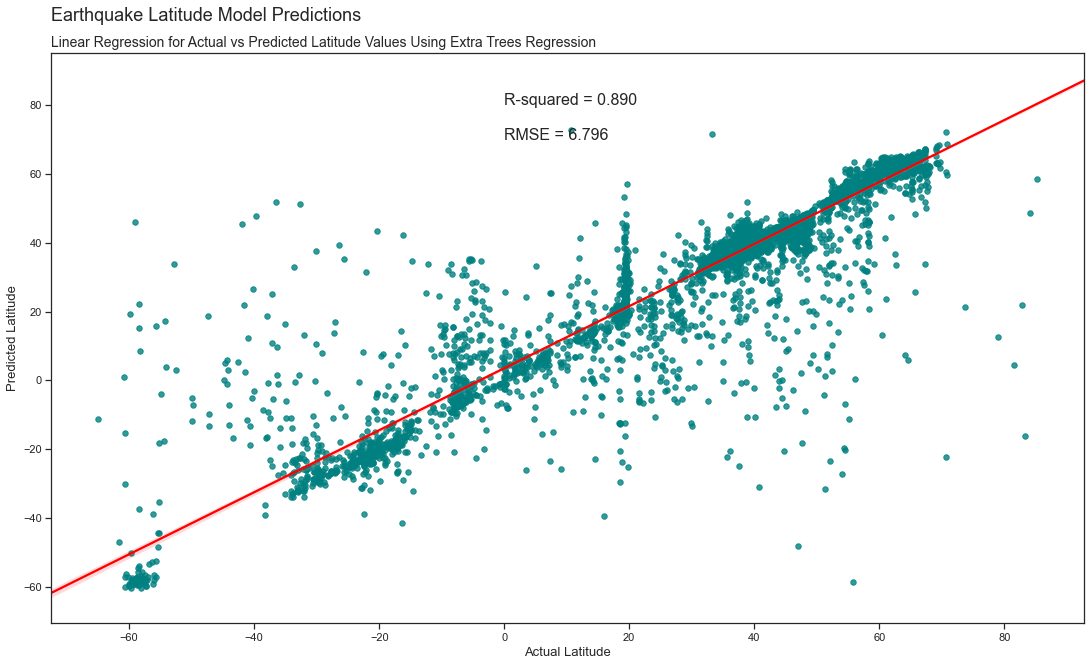

In [26]:
#plot actual vs predicted values
x = np.array(lat_pred_all['latitude'])
y = np.array(testpredict)


sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'teal'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle('Earthquake Latitude Model Predictions', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Extra Trees Regression', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(lat_pred_all['latitude'], testpredict)), (0, 80),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 70), fontsize=16)

fig.savefig('../static/images/extratrees_latnotime_linear_sns.png', bbox_inches='tight',dpi=600)
plt.show()

In [27]:
# make a single prediction
from datetime import datetime
mag = float(input('Enter a magnitude: '))
lon = float(input('Enter a longitude (in decimal form; negative for west of meridian): '))
depth = float(input('Enter a depth (in km, only numerical value): '))
# date_input = input('Enter a date (yyyy/mm/dd): ')
# time_input = input('Enter a time in UTC: ')
# datetime_str = date_input + ' '+ time_input
# date_time_obj = datetime.strptime(datetime_str, '%Y/%m/%d %H:%M:%S')
# date_time_unix = (time.mktime(date_time_obj.timetuple()))
single_features = [[mag,lon,depth]]
y_pred = best_model.predict(single_features)
print('Predicted Latitude: %g' % y_pred)

Predicted Latitude: 40.9938


Test with new data from USGS


In [28]:
#obtain USGS data for the day
page_url = "https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.csv"

test_df = pd.read_csv(page_url)
test_df


,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-05-13T16:05:48.880Z,38.843334,-122.818001,1.200000,0.86,md,13.0,83.0,0.01206,0.03,...,2022-05-13T16:14:09.895Z,"9km WNW of Cobb, CA",earthquake,0.26,0.59,NaN,1.0,automatic,nc,nc
1,2022-05-13T15:46:53.330Z,19.185499,-155.500504,33.990002,2.97,ml,44.0,77.0,NaN,0.14,...,2022-05-13T16:05:52.661Z,"3 km SW of Pāhala, Hawaii",earthquake,0.52,0.69,3.620000,30.0,automatic,hv,hv
2,2022-05-13T15:33:10.120Z,38.772499,-122.724167,1.750000,0.68,md,10.0,81.0,0.01090,0.02,...,2022-05-13T15:41:11.662Z,"3km W of Anderson Springs, CA",earthquake,0.34,0.60,0.160000,2.0,automatic,nc,nc
3,2022-05-13T15:32:57.775Z,61.664900,-150.688100,39.900000,3.30,ml,NaN,NaN,NaN,0.62,...,2022-05-13T16:14:17.105Z,"16 km NW of Susitna, Alaska",earthquake,NaN,0.90,NaN,NaN,automatic,ak,ak
4,2022-05-13T15:30:48.897Z,61.413700,-145.297800,0.000000,1.30,ml,NaN,NaN,NaN,0.54,...,2022-05-13T15:32:53.587Z,"27 km SSW of Tonsina, Alaska",earthquake,NaN,0.40,NaN,NaN,automatic,ak,ak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2022-05-12T16:47:50.820Z,19.160999,-155.368835,32.240002,2.14,md,41.0,177.0,NaN,0.13,...,2022-05-12T16:51:01.210Z,"12 km ESE of Pāhala, Hawaii",earthquake,0.74,1.32,1.010000,23.0,automatic,hv,hv
238,2022-05-12T16:43:28.031Z,-20.043300,-69.229700,100.250000,4.00,mb,NaN,69.0,0.12000,0.79,...,2022-05-13T03:37:06.060Z,"98 km E of Iquique, Chile",earthquake,4.70,3.20,0.211000,6.0,reviewed,us,us
239,2022-05-12T16:39:50.580Z,60.014500,-153.076833,1.410000,-0.98,ml,4.0,141.0,NaN,0.08,...,2022-05-13T05:51:11.460Z,"62 km ENE of Pedro Bay, Alaska",earthquake,0.34,0.32,0.184273,4.0,reviewed,av,av
240,2022-05-12T16:24:45.542Z,61.504500,-146.135100,19.500000,0.90,ml,NaN,NaN,NaN,0.14,...,2022-05-12T16:36:56.333Z,"43 km NNE of Valdez, Alaska",earthquake,NaN,0.20,NaN,NaN,automatic,ak,ak


In [29]:
#dropped columns not needed
cleaned_test_df = test_df.drop(columns=['id', 'nst','rms','magNst','net', 'time', 'magType', 'gap','dmin', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'status', 'locationSource', 'magSource'])
cleaned_test_df


,latitude,longitude,depth,mag
0,38.843334,-122.818001,1.200000,0.86
1,19.185499,-155.500504,33.990002,2.97
2,38.772499,-122.724167,1.750000,0.68
3,61.664900,-150.688100,39.900000,3.30
4,61.413700,-145.297800,0.000000,1.30
...,...,...,...,...
237,19.160999,-155.368835,32.240002,2.14
238,-20.043300,-69.229700,100.250000,4.00
239,60.014500,-153.076833,1.410000,-0.98
240,61.504500,-146.135100,19.500000,0.90


In [30]:

#find if any column has NaNs
cleaned_test_df.isnull().sum()


latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [31]:

#establish features to be used in model. X will use: latitude, longitude, depth and unix time. Y will be magnitude
X_test_data = cleaned_test_df.drop(['latitude'], axis = 1)

y_test_data = cleaned_test_df[['latitude']]


In [32]:
#use best model to predict data
pred_data_y = best_model.predict(X_test_data)


In [33]:
#create dataframe with predicted values
test_pred_data = cleaned_test_df
test_pred_data['Predicted'] = pred_data_y
test_pred_data


,latitude,longitude,depth,mag,Predicted
0,38.843334,-122.818001,1.200000,0.86,38.839967
1,19.185499,-155.500504,33.990002,2.97,19.212183
2,38.772499,-122.724167,1.750000,0.68,38.774528
3,61.664900,-150.688100,39.900000,3.30,59.312923
4,61.413700,-145.297800,0.000000,1.30,63.283483
...,...,...,...,...,...
237,19.160999,-155.368835,32.240002,2.14,19.217406
238,-20.043300,-69.229700,100.250000,4.00,-18.589810
239,60.014500,-153.076833,1.410000,-0.98,60.017889
240,61.504500,-146.135100,19.500000,0.90,63.192100


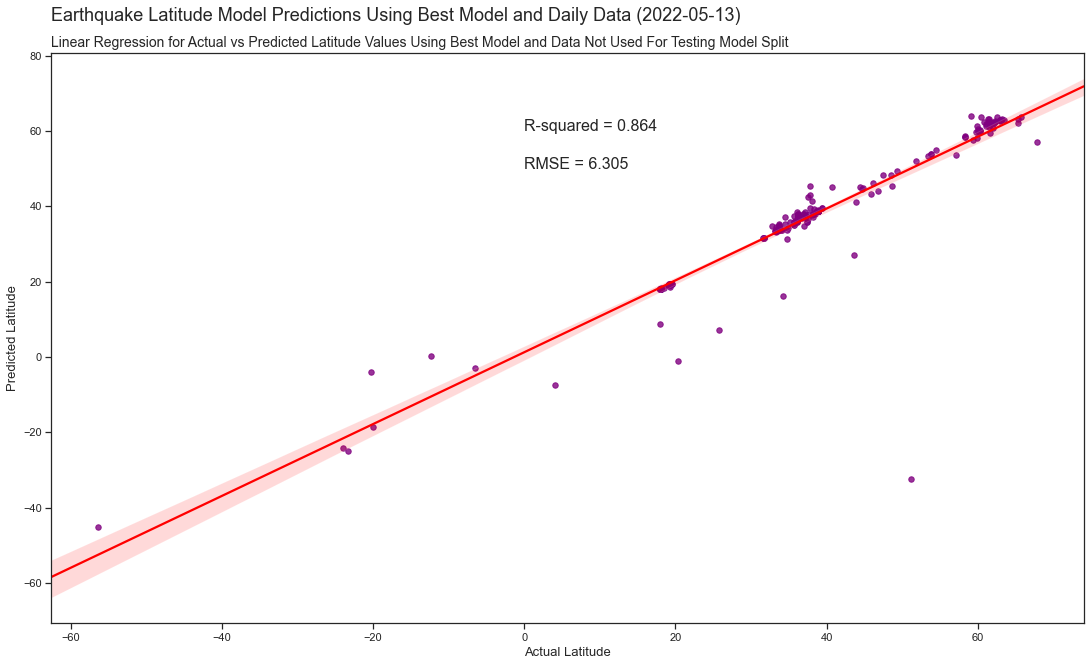

In [34]:
from datetime import date
today = date.today()
#create grpah for actual vs predicted values
x = np.array(test_pred_data['latitude'])
y = np.array(pred_data_y)
test_mse = mean_squared_error(x, y)
rmse = sqrt(test_mse)

sns.set_style('ticks')
x,y = pd.Series(x, name="Actual"), pd.Series(y, name="Prediction")
# sns.lmplot(x ='Actual', y ='Prediction', data = mag_pred_all, markers =['o'],  palette ='coolwarm')
ax = sns.regplot(x=x, y=y, ci=95, truncate=False, scatter_kws={"s": 30, "color":'purple'}, line_kws={"color": "red"})
ax.set_axisbelow(True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.ylabel('Predicted Latitude', fontsize=13)
plt.xlabel('Actual Latitude',  fontsize=13)
# Bigger title
plt.suptitle(f'Earthquake Latitude Model Predictions Using Best Model and Daily Data ({today})', x=0.125, y=0.94, ha='left', fontsize=18)
# Subtitle
plt.title('Linear Regression for Actual vs Predicted Latitude Values Using Best Model and Data Not Used For Testing Model Split', loc='left', fontsize=14)
plt.annotate("R-squared = {:.3f}".format(r2_score(x, y)), (0, 60),  fontsize=16)
plt.annotate("RMSE = {:.3f}".format(rmse), (0, 50), fontsize=16)

fig.savefig('../static/images/extratrees_latnotime_linear_sns_daily.png', bbox_inches='tight',dpi=600)
plt.show()

In [35]:
#connection to a PostgreSQL local database
# ===========================================

# user_name_var = input('What is the username of your database? ')
host_var = input('What is the host address of your database?')
pw = input("Enter the database password: ")
# db_name = input("Enter the name of the database: ")

string_output = "postgresql://postgres"+':'+pw+'@'+host_var+":5432"+'/earthquake_db'
engine = create_engine(string_output)
connection = engine.connect()
print("Connected to database...")

Connected to database...


In [36]:
#create new database with predicted values for both training and test databases
#=============
#PostgreSQL
lat_pred_all.to_sql('earthquake_etrees_lat_notime', engine, if_exists='replace', index = False)
#=============
#SQLite
cur = conn.cursor()
lat_pred_all.to_sql('earthquake_etrees_lat_notime', conn, if_exists='replace', index=False)

14815

In [37]:
# Close connection to SQLite database
conn.close()
connection.close()